In [2]:
pip install pyemma


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
import pyemma.msm as msm

import matplotlib
import seaborn
import matplotlib.dates as md
from matplotlib import pyplot as plt

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.covariance import EllipticEnvelope
#from pyemma import msm # not available on Kaggle Kernel
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM

In [4]:
df = pd.read_csv("../Data/archive/realKnownCause/realKnownCause/ambient_temperature_system_failure.csv")

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  7267 non-null   object 
 1   value      7267 non-null   float64
dtypes: float64(1), object(1)
memory usage: 113.7+ KB


In [6]:
df.describe()

,value
count,7267.000000
mean,71.242433
std,4.247509
min,57.458406
25%,68.369411
50%,71.858493
75%,74.430958
max,86.223213


In [7]:
df.head()

,timestamp,value
0,2013-07-04 00:00:00,69.880835
1,2013-07-04 01:00:00,71.220227
2,2013-07-04 02:00:00,70.877805
3,2013-07-04 03:00:00,68.959400
4,2013-07-04 04:00:00,69.283551


<Axes: xlabel='timestamp'>

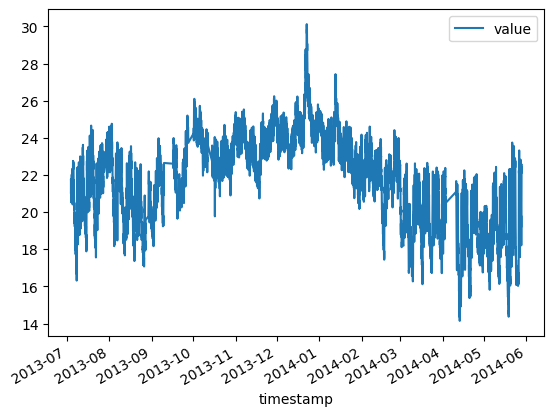

In [8]:
# change the type of timestamp column for plotting
df['timestamp'] = pd.to_datetime(df['timestamp'])
# change fahrenheit to °C (temperature mean= 71 -> fahrenheit)
df['value'] = (df['value'] - 32) * 5/9
# plot the data
df.plot(x='timestamp', y='value')

# Feature Engineering

In [9]:
df['hours'] = df['timestamp'].dt.hour
df['daylight'] = ((df['hours'] >= 7) & (df['hours'] <= 22)).astype(int)

df['DayOfTheWeek'] = df['timestamp'].dt.dayofweek
df['WeekDay'] = (df['DayOfTheWeek'] < 5).astype(int)
# An estimation of anomly population of the dataset (necessary for several algorithm)
outliers_fraction = 0.01

In [10]:
#convert into epoch time
df['time_epoch'] = (df['timestamp'].astype(np.int64)/100000000000).astype(np.int64)

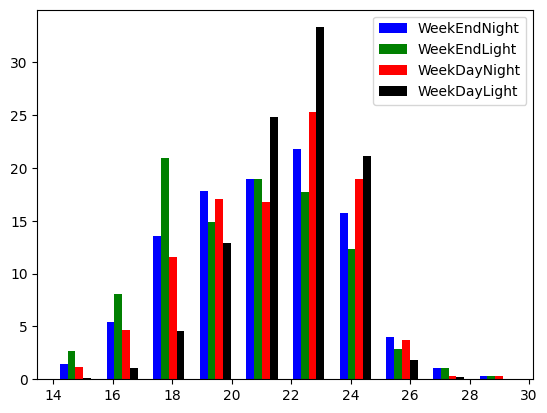

In [11]:
df['categories'] = df['WeekDay']*2 + df['daylight']

a = df.loc[df['categories'] == 0, 'value']
b = df.loc[df['categories'] == 1, 'value']
c = df.loc[df['categories'] == 2, 'value']
d = df.loc[df['categories'] == 3, 'value']

fig, ax = plt.subplots()
a_heights, a_bins = np.histogram(a)
b_heights, b_bins = np.histogram(b, bins=a_bins)
c_heights, c_bins = np.histogram(c, bins=a_bins)
d_heights, d_bins = np.histogram(d, bins=a_bins)

width = (a_bins[1] - a_bins[0])/6

ax.bar(a_bins[:-1], a_heights*100/a.count(), width=width, facecolor='blue', label='WeekEndNight')
ax.bar(b_bins[:-1]+width, (b_heights*100/b.count()), width=width, facecolor='green', label ='WeekEndLight')
ax.bar(c_bins[:-1]+width*2, (c_heights*100/c.count()), width=width, facecolor='red', label ='WeekDayNight')
ax.bar(d_bins[:-1]+width*3, (d_heights*100/d.count()), width=width, facecolor='black', label ='WeekDayLight')

plt.legend()
plt.show()

Temp seems to be more stable during the week and during the day

# Models

## Clusters
Using for collective anomalies

In [12]:
data = df[['value', 'hours', 'daylight', 'DayOfTheWeek', 'WeekDay']]
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)
# reduce to 2 importants features
pca = PCA(n_components=2)
data = pca.fit_transform(data)
# standardize these 2 new features
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)

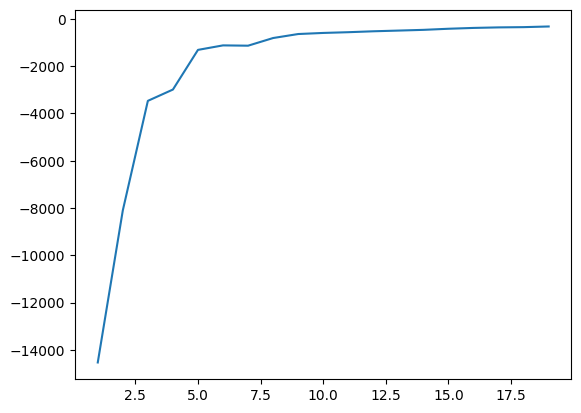

In [13]:
# calculate with different number of centroids to see the loss plot (elbow method)
n_cluster = range(1, 20)
kmeans = [KMeans(n_clusters=i).fit(data) for i in n_cluster]
scores = [kmeans[i].score(data) for i in range(len(kmeans))]
fig, ax = plt.subplots()
ax.plot(n_cluster, scores)
plt.show()

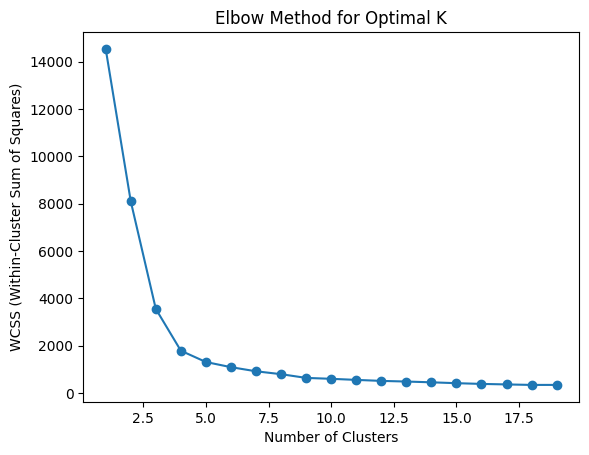

In [14]:
# Calculate WCSS (Within-Cluster Sum of Squares) for different number of clusters
n_cluster = range(1, 20)
wcss = []

# Fit KMeans and calculate WCSS for each number of clusters
for i in n_cluster:
    kmeans = KMeans(n_clusters=i).fit(data)
    wcss.append(kmeans.inertia_)  # .inertia_ is the WCSS value for the given cluster

# Plot the WCSS values to visualize the elbow
fig, ax = plt.subplots()
ax.plot(n_cluster, wcss, marker='o')
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('WCSS (Within-Cluster Sum of Squares)')
ax.set_title('Elbow Method for Optimal K')
plt.show()

Elbow point at K = 4

In [15]:
kmeans_4 = KMeans(n_clusters=4)
kmeans_4.fit(data)

# Predict clusters and add the cluster assignments to the DataFrame
df['cluster'] = kmeans_4.predict(data)

# Since 'data' is a pandas DataFrame, use .iloc to assign the first and second columns to principal features
df['principal_feature1'] = data.iloc[:, 0]  # First column of DataFrame
df['principal_feature2'] = data.iloc[:, 1]  # Second column of DataFrame

# View the counts of each cluster
print(df['cluster'].value_counts())

cluster
1    3721
2    1522
3    1428
0     596
Name: count, dtype: int64


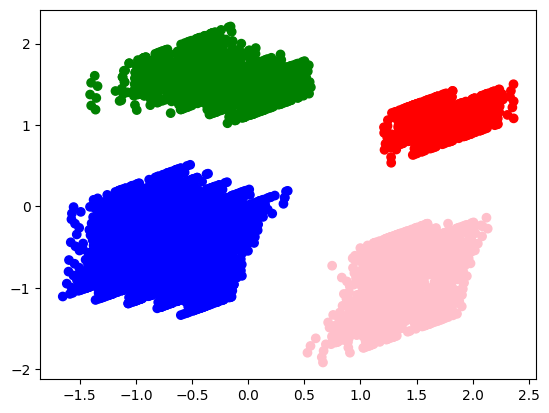

In [16]:
fig, ax = plt.subplots()
colors = {0:'red', 1:'blue', 2:'green', 3:'pink', 4:'black', 5:'orange', 6:'cyan', 7:'yellow', 8:'brown', 9:'purple', 10:'white', 11: 'grey', 12:'lightblue', 13:'lightgreen', 14: 'darkgrey'}
ax.scatter(df['principal_feature1'], df['principal_feature2'], c=df["cluster"].apply(lambda x: colors[x]))
plt.show()

In [17]:
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd

# Define the updated function
def getDistanceByPoint(data, model):
    distance = pd.Series(np.zeros(len(data))) # Initialize the Series with zeros
    for i in range(len(data)):
        Xa = np.array(data.iloc[i]) # Use .iloc to access rows by index
        Xb = model.cluster_centers_[model.labels_[i] - 1]
        distance[i] = np.linalg.norm(Xa - Xb)
    return distance

# Assuming data is a pandas DataFrame
kmeans_4 = KMeans(n_clusters=4)
kmeans_4.fit(data)

# Calculate distances of each point to its assigned cluster centroid
distance = getDistanceByPoint(data, kmeans_4)

# Set the fraction of outliers
outliers_fraction = 0.01

# Calculate the number of outliers
number_of_outliers = int(outliers_fraction * len(distance))

# Find the threshold for classifying outliers
threshold = distance.nlargest(number_of_outliers).min()

# Flagging the anomalies
df['is_anomaly'] = distance > threshold

# Show the counts of anomalies
print(df['is_anomaly'].value_counts())


is_anomaly
False    7196
True       71
Name: count, dtype: int64


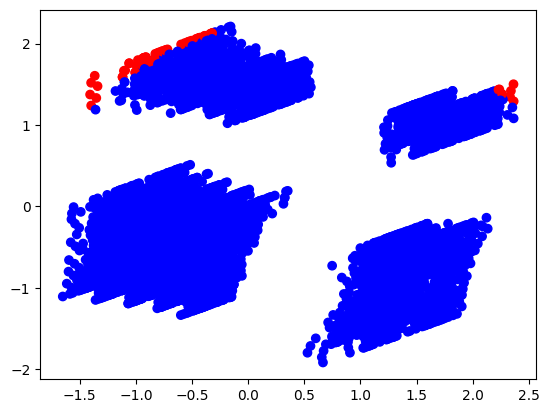

In [18]:
fig, ax = plt.subplots()
colors = {0:'blue', 1:'red'}
ax.scatter(df['principal_feature1'], df['principal_feature2'], c=df["is_anomaly"].apply(lambda x: colors[x]))
plt.show()

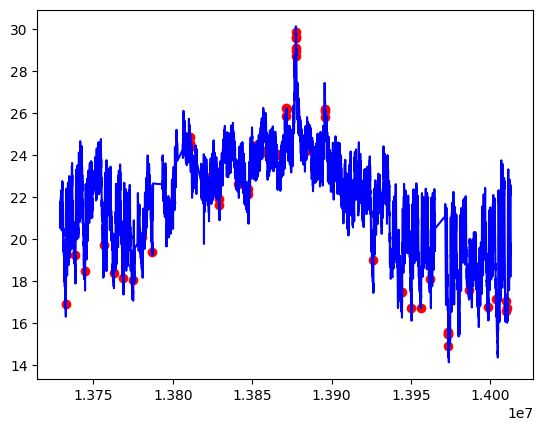

In [19]:
fig, ax = plt.subplots()

a = df.loc[df['is_anomaly'] == 1, ['time_epoch', 'value']] #anomaly

ax.plot(df['time_epoch'], df['value'], color='blue')
ax.scatter(a['time_epoch'],a['value'], color='red')
plt.show()

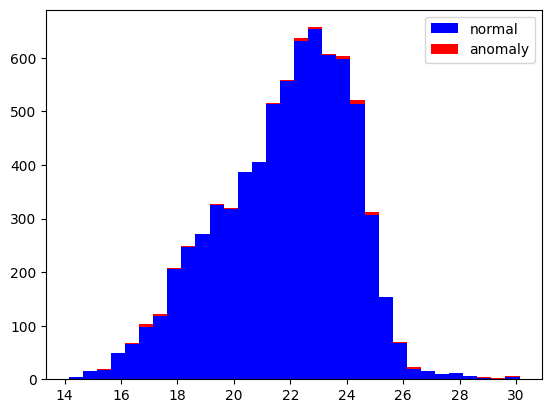

In [20]:
a = df.loc[df['is_anomaly'] == 0, 'value']
b = df.loc[df['is_anomaly'] == 1, 'value']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
plt.legend()
plt.show()


# Gaussian and Categories

In [21]:
df_class0 = df.loc[df['categories'] == 0, 'value']
df_class1 = df.loc[df['categories'] == 1, 'value']
df_class2 = df.loc[df['categories'] == 2, 'value']
df_class3 = df.loc[df['categories'] == 3, 'value']

<Axes: >

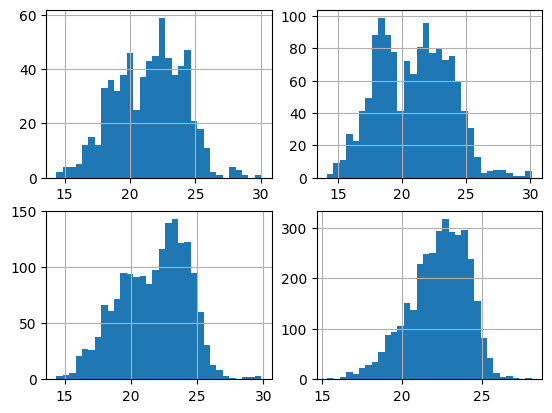

In [22]:
fig, axs = plt.subplots(2,2)
df_class0.hist(ax=axs[0,0],bins=32)
df_class1.hist(ax=axs[0,1],bins=32)
df_class2.hist(ax=axs[1,0],bins=32)
df_class3.hist(ax=axs[1,1],bins=32)

In [23]:
# apply ellipticEnvelope(gaussian distribution) at each categories
envelope =  EllipticEnvelope(contamination = outliers_fraction) 
X_train = df_class0.values.reshape(-1,1)
envelope.fit(X_train)
df_class0 = pd.DataFrame(df_class0)
df_class0['deviation'] = envelope.decision_function(X_train)
df_class0['anomaly'] = envelope.predict(X_train)

envelope =  EllipticEnvelope(contamination = outliers_fraction) 
X_train = df_class1.values.reshape(-1,1)
envelope.fit(X_train)
df_class1 = pd.DataFrame(df_class1)
df_class1['deviation'] = envelope.decision_function(X_train)
df_class1['anomaly'] = envelope.predict(X_train)

envelope =  EllipticEnvelope(contamination = outliers_fraction) 
X_train = df_class2.values.reshape(-1,1)
envelope.fit(X_train)
df_class2 = pd.DataFrame(df_class2)
df_class2['deviation'] = envelope.decision_function(X_train)
df_class2['anomaly'] = envelope.predict(X_train)

envelope =  EllipticEnvelope(contamination = outliers_fraction) 
X_train = df_class3.values.reshape(-1,1)
envelope.fit(X_train)
df_class3 = pd.DataFrame(df_class3)
df_class3['deviation'] = envelope.decision_function(X_train)
df_class3['anomaly'] = envelope.predict(X_train)

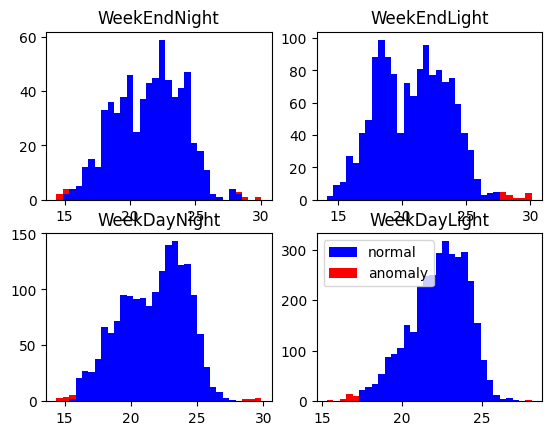

In [24]:
# plot the temperature repartition by categories with anomalies
a0 = df_class0.loc[df_class0['anomaly'] == 1, 'value']
b0 = df_class0.loc[df_class0['anomaly'] == -1, 'value']

a1 = df_class1.loc[df_class1['anomaly'] == 1, 'value']
b1 = df_class1.loc[df_class1['anomaly'] == -1, 'value']

a2 = df_class2.loc[df_class2['anomaly'] == 1, 'value']
b2 = df_class2.loc[df_class2['anomaly'] == -1, 'value']

a3 = df_class3.loc[df_class3['anomaly'] == 1, 'value']
b3 = df_class3.loc[df_class3['anomaly'] == -1, 'value']

fig, axs = plt.subplots(2,2)
axs[0,0].hist([a0,b0], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
axs[0,1].hist([a1,b1], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
axs[1,0].hist([a2,b2], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
axs[1,1].hist([a3,b3], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
axs[0,0].set_title("WeekEndNight")
axs[0,1].set_title("WeekEndLight")
axs[1,0].set_title("WeekDayNight")
axs[1,1].set_title("WeekDayLight")
plt.legend()
plt.show()

In [25]:
df_class = pd.concat([df_class0, df_class1, df_class2, df_class3])
df['anomaly22'] = df_class['anomaly']
df['anomaly22'] = np.array(df['anomaly22'] == -1).astype(int) 

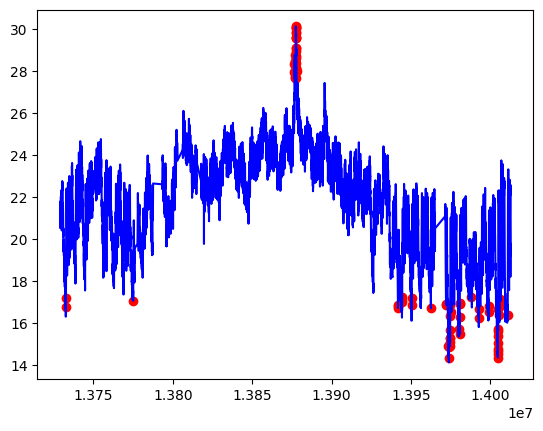

In [26]:
# visualisation of anomaly throughout time
fig, ax = plt.subplots()

a = df.loc[df['anomaly22'] == 1, ('time_epoch', 'value')] #anomaly

ax.plot(df['time_epoch'], df['value'], color='blue')
ax.scatter(a['time_epoch'],a['value'], color='red')
plt.show()

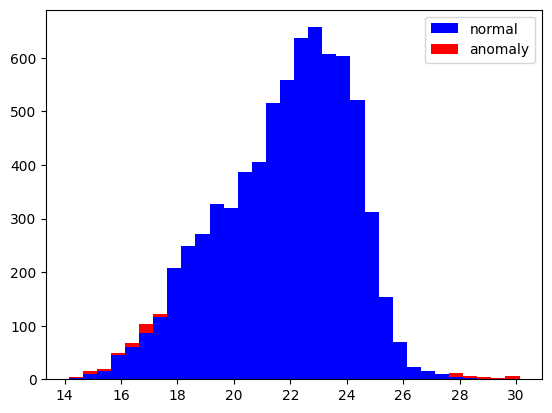

In [27]:
# visualisation of anomaly with temperature repartition (viz 2)
a = df.loc[df['anomaly22'] == 0, 'value']
b = df.loc[df['anomaly22'] == 1, 'value']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
plt.legend()
plt.show()

Good detections of extreme values and context separation add some precision to the detection.

## Markov Chains

In [32]:
def getTransitionMatrix(sequence):
    n_states = len(np.unique(sequence))
    transition_matrix = np.zeros((n_states, n_states))

    for i in range(len(sequence) - 1):
        transition_matrix[sequence[i], sequence[i+1]] += 1

    # Normalize the rows to make it a proper transition probability matrix
    transition_matrix = transition_matrix / transition_matrix.sum(axis=1, keepdims=True)

    return transition_matrix



    
def markovAnomaly(sequence, window_size, threshold):
    transition_matrix = getTransitionMatrix(sequence)
    real_threshold = threshold ** window_size
    df_anomaly = []
    
    for j in range(0, len(sequence)):
        if j < window_size:
            df_anomaly.append(0)  # Not enough data for a sequence yet
        else:
            subsequence = sequence[j-window_size:j].values  # Subsequence of the last `window_size` elements
            anomaly_score = 1
            for k in range(window_size - 1):
                # Multiply the transition probabilities for the entire subsequence
                anomaly_score *= transition_matrix[subsequence[k], subsequence[k+1]]

            # Append 1 if the anomaly score is below the threshold, otherwise 0
            df_anomaly.append(1 if anomaly_score < real_threshold else 0)
    
    return df_anomaly


# definition of the different state
x1 = (df['value'] <=18).astype(int)
x2= ((df['value'] > 18) & (df['value']<=21)).astype(int)
x3 = ((df['value'] > 21) & (df['value']<=24)).astype(int)
x4 = ((df['value'] > 24) & (df['value']<=27)).astype(int)
x5 = (df['value'] >27).astype(int)
df_mm = 0*x1 + 1*x2 + 2*x3 + 3*x4 + 4*x5

df_anomaly = markovAnomaly(df_mm, 5, 0.20)
df_anomaly = pd.Series(df_anomaly)
print(df_anomaly.value_counts())


0    7147
1     120
Name: count, dtype: int64


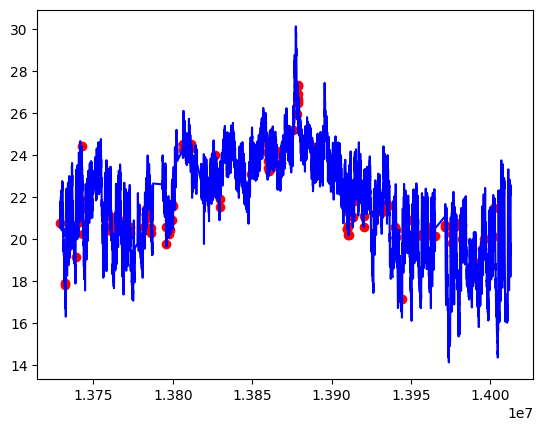

In [33]:
# add the data to the main 
df['anomaly_mc'] = df_anomaly

# visualisation of anomaly throughout time (viz 1)
fig, ax = plt.subplots()

a = df.loc[df['anomaly_mc'] == 1, ('time_epoch', 'value')] #anomaly

ax.plot(df['time_epoch'], df['value'], color='blue')
ax.scatter(a['time_epoch'],a['value'], color='red')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


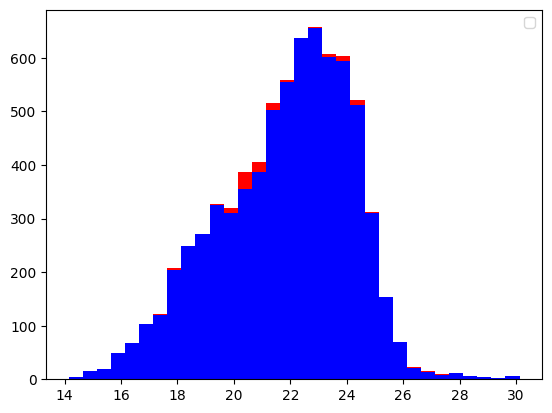

In [34]:
# visualisation of anomaly with temperature repartition (viz 2)
a = df.loc[df['anomaly_mc'] == 0, 'value']
b = df.loc[df['anomaly_mc'] == 1, 'value']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'])
plt.legend()
plt.show()

Detect unusual sequence but not extreme value. More difficult to evaluate the relevance on this example. The sequence size (5) should be match with some interesting cycle.

## Isolation Forest

In [35]:
data = df[['value', 'hours', 'daylight', 'DayOfTheWeek', 'WeekDay']]
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)
# train isolation forest 
model =  IsolationForest(contamination = outliers_fraction)
model.fit(data)
# add the data to the main  
df['anomaly_IF'] = pd.Series(model.predict(data))
df['anomaly_IF'] = df['anomaly_IF'].map( {1: 0, -1: 1} )
print(df['anomaly_IF'].value_counts())

anomaly_IF
0    7194
1      73
Name: count, dtype: int64


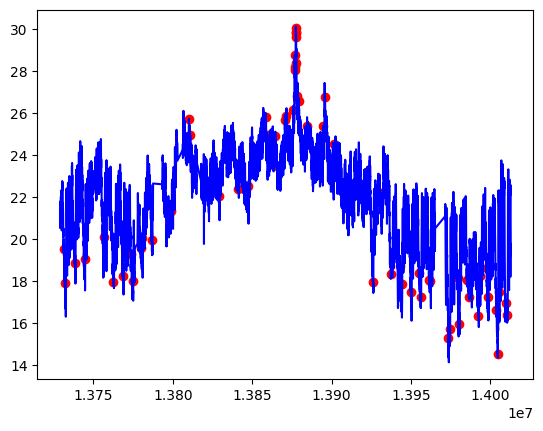

In [36]:
fig, ax = plt.subplots()

a = df.loc[df['anomaly_IF'] == 1, ['time_epoch', 'value']] #anomaly

ax.plot(df['time_epoch'], df['value'], color='blue')
ax.scatter(a['time_epoch'],a['value'], color='red')
plt.show()

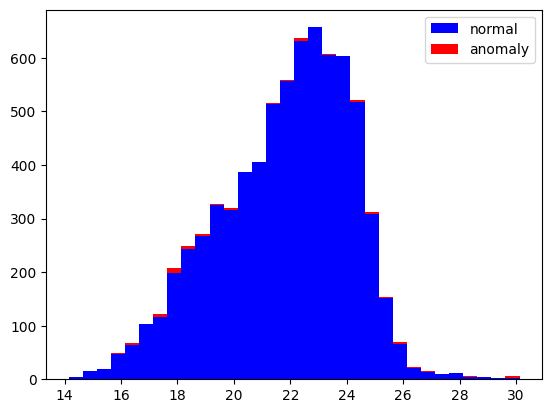

In [37]:
a = df.loc[df['anomaly_IF'] == 0, 'value']
b = df.loc[df['anomaly_IF'] == 1, 'value']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'], label = ['normal', 'anomaly'])
plt.legend()
plt.show()

## One class SVM

In [38]:
data = df[['value', 'hours', 'daylight', 'DayOfTheWeek', 'WeekDay']]
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
# train one class SVM 
model =  OneClassSVM(nu=0.95 * outliers_fraction) #nu=0.95 * outliers_fraction  + 0.05
data = pd.DataFrame(np_scaled)
model.fit(data)
# add the data to the main  
df['anomalySVM'] = pd.Series(model.predict(data))
df['anomalySVM'] = df['anomalySVM'].map( {1: 0, -1: 1} )
print(df['anomalySVM'].value_counts())

anomalySVM
0    7198
1      69
Name: count, dtype: int64


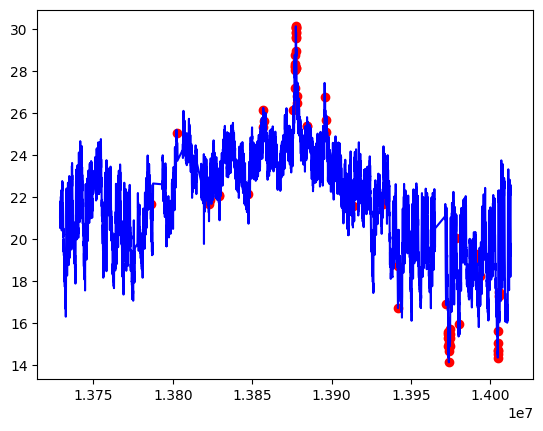

In [39]:
fig, ax = plt.subplots()

a = df.loc[df['anomalySVM'] == 1, ['time_epoch', 'value']] #anomaly

ax.plot(df['time_epoch'], df['value'], color='blue')
ax.scatter(a['time_epoch'],a['value'], color='red')
plt.show()

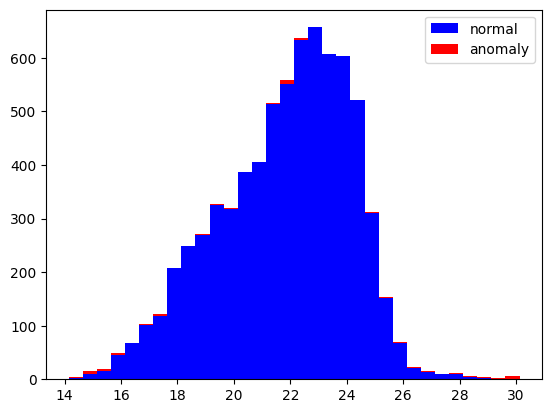

In [40]:
a = df.loc[df['anomalySVM'] == 0, 'value']
b = df.loc[df['anomalySVM'] == 1, 'value']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
plt.legend()
plt.show()

## RNN

use for sequential anomalies (ordered)

In [41]:
data_n = df[['value', 'hours', 'daylight', 'DayOfTheWeek', 'WeekDay']]
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data_n)
data_n = pd.DataFrame(np_scaled)

# important parameters and train/test size
prediction_time = 1 
testdatasize = 1000
unroll_length = 50
testdatacut = testdatasize + unroll_length  + 1

#train data
x_train = data_n[0:-prediction_time-testdatacut].values
y_train = data_n[prediction_time:-testdatacut  ][0].values

# test data
x_test = data_n[0-testdatacut:-prediction_time].values
y_test = data_n[prediction_time-testdatacut:  ][0].values

In [42]:
def unroll(data,sequence_length=24):
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    return np.asarray(result)

# adapt the datasets for the sequence data shape
x_train = unroll(x_train,unroll_length)
x_test  = unroll(x_test,unroll_length)
y_train = y_train[-x_train.shape[0]:]
y_test  = y_test[-x_test.shape[0]:]

# see the shape
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (6165, 50, 5)
y_train (6165,)
x_test (1000, 50, 5)
y_test (1000,)


In [43]:
from tensorflow.keras.layers import Dense, Activation, Dropout, LSTM
from keras.models import Sequential
import time #helper libraries
from keras.models import model_from_json
import sys

In [44]:
model = Sequential()

model.add(LSTM(
    units=50,  # Replace output_dim with units
    input_shape=(x_train.shape[1], x_train.shape[2]),  # Use input_shape instead of input_dim
    return_sequences=True))
model.add(Dropout(0.2))

# Second LSTM layer with Dropout
model.add(LSTM(
    units=100,  # Define the number of LSTM units
    return_sequences=False))  # Last LSTM layer, no need to return sequences
model.add(Dropout(0.2))

# Output layer with linear activation
model.add(Dense(units=1))  # Single unit output
model.add(Activation('linear'))

# Compile the model
start = time.time()
model.compile(loss='mse', optimizer='rmsprop')  # Compiling with MSE loss and RMSprop optimizer
print('compilation time : {}'.format(time.time() - start))

2024-09-11 11:31:06.597149: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2024-09-11 11:31:06.597178: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-09-11 11:31:06.597205: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-09-11 11:31:06.597269: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-09-11 11:31:06.597302: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


compilation time : 0.007096052169799805


In [45]:
model.fit(
    x_train,
    y_train,
    batch_size=3028,
    epochs=30,
    validation_split=0.1)

Epoch 1/30


2024-09-11 11:31:07.705090: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 2s 706ms/step - loss: 0.5343 - val_loss: 0.5761
Epoch 2/30
2/2 [==============================] - 0s 143ms/step - loss: 0.1876 - val_loss: 0.2786
Epoch 3/30
2/2 [==============================] - 0s 135ms/step - loss: 0.1154 - val_loss: 0.2019
Epoch 4/30
2/2 [==============================] - 0s 139ms/step - loss: 0.1141 - val_loss: 0.1825
Epoch 5/30
2/2 [==============================] - 0s 135ms/step - loss: 0.1026 - val_loss: 0.1783
Epoch 6/30
2/2 [==============================] - 0s 136ms/step - loss: 0.0918 - val_loss: 0.1648
Epoch 7/30
2/2 [==============================] - 0s 133ms/step - loss: 0.0844 - val_loss: 0.1514
Epoch 8/30
2/2 [==============================] - 0s 147ms/step - loss: 0.0808 - val_loss: 0.1433
Epoch 9/30
2/2 [==============================] - 0s 136ms/step - loss: 0.0770 - val_loss: 0.1382
Epoch 10/30
2/2 [==============================] - 0s 134ms/step - loss: 0.0762 - val_loss: 0.1312
Epoch 11/30
2/2 [=============

In [46]:
loaded_model = model
diff=[]
ratio=[]
p = loaded_model.predict(x_test)
# predictions = lstm.predict_sequences_multiple(loaded_model, x_test, 50, 50)
for u in range(len(y_test)):
    pr = p[u][0]
    ratio.append((y_test[u]/pr)-1)
    diff.append(abs(y_test[u]- pr))

32/32 [==============================] - 0s 5ms/step


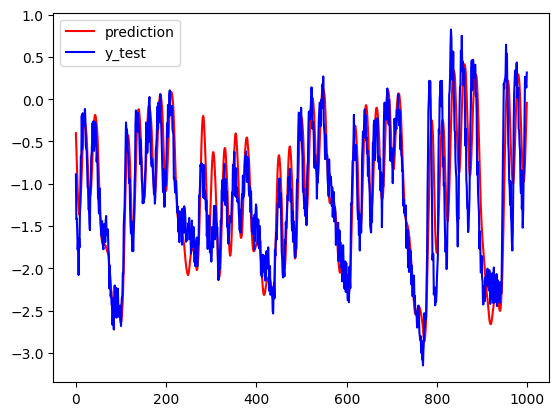

In [47]:
# plot the prediction and the reality (for the test data)
fig, axs = plt.subplots()
axs.plot(p,color='red', label='prediction')
axs.plot(y_test,color='blue', label='y_test')
plt.legend(loc='upper left')
plt.show()

In [48]:
# select the most distant prediction/reality data points as anomalies
diff = pd.Series(diff)
number_of_outliers = int(outliers_fraction*len(diff))
threshold = diff.nlargest(number_of_outliers).min()
# data with anomaly label (test data part)
test = (diff >= threshold).astype(int)
# the training data part where we didn't predict anything (overfitting possible): no anomaly
# Complement series for the non-predicted training part
complement = pd.Series(0, index=np.arange(len(data_n)-testdatasize))

# Concatenate the complement and test series
df['anomalyRNN'] = pd.concat([complement, test], ignore_index=True)

# Check the distribution of anomalies
print(df['anomalyRNN'].value_counts())

anomalyRNN
0    7257
1      10
Name: count, dtype: int64


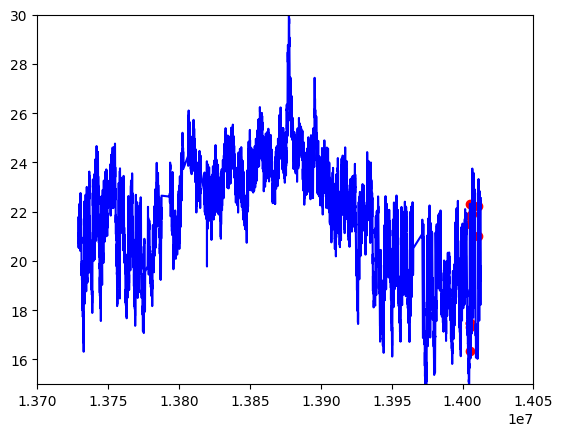

In [49]:
fig, ax = plt.subplots()

a = df.loc[df['anomalyRNN'] == 1, ['time_epoch', 'value']] #anomaly

ax.plot(df['time_epoch'], df['value'], color='blue')
ax.scatter(a['time_epoch'],a['value'], color='red')
plt.axis([1.370*1e7, 1.405*1e7, 15,30])
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


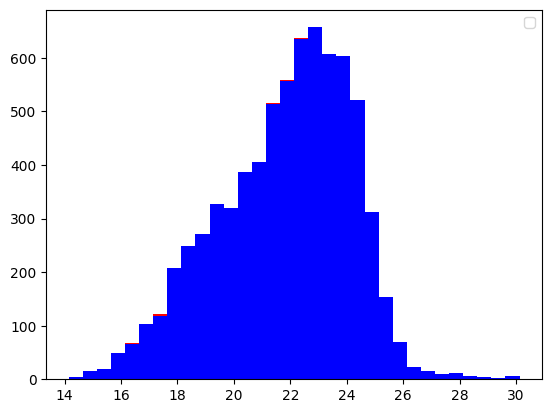

In [50]:
a = df.loc[df['anomalyRNN'] == 0, 'value']
b = df.loc[df['anomalyRNN'] == 1, 'value']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'])
plt.legend()
plt.show()